In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy
import glob
import os
from sklearn.metrics import root_mean_squared_error,r2_score
import seaborn as sns

In [35]:
CIs = []

def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../dados/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = []

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']


    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        print(file)
        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
        CIs.append(df.iloc[0,:4].to_numpy())
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]
    return data_frames,csv_files 
data_frames,file_list = import_dfs()
print(data_frames[0].columns)
print(file_list)
print(CIs)

../dados\25.45nh60ab20.csv
../dados\25.46nh30ab30.csv
../dados\25.47nh5ab80.csv
../dados\5.100nh40ab80.csv
../dados\5.102nh20ab40.csv
../dados\5.103nh40ab30.csv
../dados\5.106nh100ab40.csv
../dados\5.107nh55ab55.csv
../dados\5.109nh5ab55.csv
../dados\5.110nh10ab55.csv
../dados\5.112nh78ab35.csv
../dados\5.48nh20ab80.csv
../dados\5.80nh12ab40.csv
../dados\5.81nh5ab30.csv
../dados\nh60ab80.csv
Index(['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm', 'apa_t'], dtype='object')
['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30', 'nh60ab80']
[array([20.,  0., 60.,  0.]), array([30.,  0., 30.,  0.]), array([80.,  0.,  5.,  0.]), array([80.,  0., 40.,  0.]), array([40.5       ,  0.        , 21.75      ,  3.37262013]), array([30.4 ,  0.  , 43.  ,  2.55]), array([4.00389864e+01, 6.40149834e-02, 1.00045181e+02, 1.42108547e+0

In [36]:
# lucas

kcat1        = 0.181 #Constante catal�tica do consumo do �ster (�mol/i.u. per min)
 
kcat2        = 0.395 #Constante catal�tica da hidr�lise da amoxicilina (�mol/i.u. per min)
 
Km1          = 5.449 #Constante de Michaelis-Menten ou constante de afinidade para consumo do �ster(mM) 
 
Km2          = 1.694 #Constante de Michaelis-Menten ou constante de afinidade para hidr�lise da amoxicilina(mM)
 
Tmax         = 0.824 #Taxa de convers�o m�xima do complexo acil-enzima-n�cleo em produto
 
Ken          = 7.947 #Constante de adsor��o do 6-APA
 
kAB          = 0.682 #Constante de inibi��o do �ster(POHPGME)(mM)
 
kAN          = 1.989 #Constante de inibi��o da amoxicilina (mM)
 
kAOH         = 9.856 #Constante de inibi��o do POHPG, produto da hidr�lise da amoxicilina (mM)
 
kNH          = 9.763 #Constante de inibi��o do 6-APA

lucas_P = np.zeros(10)
lucas_P[0]   = kcat1    
lucas_P[1]   = kcat2    
lucas_P[2]   = Km1      
lucas_P[3]   = Km2      
lucas_P[4]   = Tmax     
lucas_P[5]   = Ken      
lucas_P[6]   = kAB      
lucas_P[7]   = kAN      
lucas_P[8]   = kAOH     
lucas_P[9]  = kNH 

In [37]:
kcat1        = 0.59 #Constante catal�tica do consumo do �ster (�mol/i.u. per min)
 
kcat2        = 3.07 #Constante catal�tica da hidr�lise da amoxicilina (�mol/i.u. per min)
 
Km1          = 0.2 #Constante de Michaelis-Menten ou constante de afinidade para consumo do �ster(mM) 
 
Km2          = 27.47 #Constante de Michaelis-Menten ou constante de afinidade para hidr�lise da amoxicilina(mM)
 
Tmax         = 0.96 #Taxa de convers�o m�xima do complexo acil-enzima-n�cleo em produto
 
Ken          = 16.03 #Constante de adsor��o do 6-APA
 
kAB          = 2672.04 #Constante de inibi��o do �ster(POHPGME)(mM)
 
kAN          = 4.59 #Constante de inibi��o da amoxicilina (mM)
 
kAOH         = 4.51 #Constante de inibi��o do POHPG, produto da hidr�lise da amoxicilina (mM)
 
kNH          = 4550.28 #Constante de inibi��o do 6-APA

process_P = np.zeros(10)
process_P[0]   = kcat1    
process_P[1]   = kcat2    
process_P[2]   = Km1      
process_P[3]   = Km2      
process_P[4]   = Tmax     
process_P[5]   = Ken      
process_P[6]   = kAB      
process_P[7]   = kAN      
process_P[8]   = kAOH
process_P[9]   = kNH

In [38]:
# luci parameters

kcat1        = 0.178 #Constante catal�tica do consumo do �ster (�mol/i.u. per min)
 
kcat2        = 0.327 #Constante catal�tica da hidr�lise da amoxicilina (�mol/i.u. per min)
 
Km1          = 7.905 #Constante de Michaelis-Menten ou constante de afinidade para consumo do �ster(mM) 
 
Km2          = 12.509 #Constante de Michaelis-Menten ou constante de afinidade para hidr�lise da amoxicilina(mM)
 
Tmax         = 0.606 #Taxa de convers�o m�xima do complexo acil-enzima-n�cleo em produto
 
Ken          = 14.350 #Constante de adsor��o do 6-APA
 
kAB          = 3.78 #Constante de inibi��o do �ster(POHPGME)(mM)
 
kAN          = 9.174 #Constante de inibi��o da amoxicilina (mM)
 
kAOH         = 10.907 #Constante de inibi��o do POHPG, produto da hidr�lise da amoxicilina (mM)
 
kNH          = 62.044 #Constante de inibi��o do 6-APA

luci_P = np.zeros(10)
luci_P[0]   = kcat1    
luci_P[1]   = kcat2    
luci_P[2]   = Km1      
luci_P[3]   = Km2      
luci_P[4]   = Tmax     
luci_P[5]   = Ken      
luci_P[6]   = kAB      
luci_P[7]   = kAN      
luci_P[8]   = kAOH     
luci_P[9]  = kNH 

In [39]:
optimized_P = np.array([1.76111242e-01, 4.28768542e-01, 1.71836876e+00, 1.42996053e-02, 9.53931641e-01, 1.82350367e+01, 3.45380244e-03, 4.84532693e-01, 2.32604795e+01, 2.39272396e+00])

In [40]:
def enzymic_amox(t,y, 
kcat1,
kcat2,
Km1,
Km2,  
Tmax, 
Ken,  
kAB,  
kAN,  
kAOH, 
kNH):
    FAB = 0
    FNH = 0 
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    Cez = 1

    # Consumo de ester
    VAB = (kcat1*CAB*Cez)/((Km1*(1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2*CAN*Cez)/((Km2*(1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X   = CNH/(Ken + CNH)
    
    # Sintese enzimatica
    VS  = VAB*Tmax*X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = ((-(VS - VAN) - (Vh1 + VAN)) + FAB) 
    
    # C. amox
    dy[1] = (VS - VAN)                         
    
    # C. 6-apa
    dy[2] = (-(VS - VAN) + FNH)                
    
    # C. POHPG
    dy[3] =  (Vh1 + VAN)
    
    return np.array(dy)  

In [41]:
def ode15s_amox(P, CI, t):
    return scipy.integrate.solve_ivp(enzymic_amox,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='BDF',args=P).y.T

In [42]:
import scipy.integrate


def ode15s_amox(P, CI, t):
    try:
        sol = scipy.integrate.solve_ivp(
            enzymic_amox, 
            t_span=(t[0], t[-1]), 
            t_eval=t, 
            y0=CI, 
            method='RK45', 
            args=P, 
            #atol=1e-8, 
            #tol=1e-6
        )
        if sol.status != 0:
            raise ValueError("ODE solver failed to converge")
        return sol.y.T
    except Exception as e:
        print(f"Solver failed with error: {e}")
        # Handle solver failure (e.g., return NaNs or retry with different parameters)
        return np.full((len(CI), len(t)), np.nan).T
    

In [53]:
def mcmc(P,priori,N=5000,ode_solver=ode15s_amox,status=False):

    Np = len(P)
    # Extraindo dados
    exps = []
    times = []
    
    for i in range(len(CIs)):
        t = data_frames[i].loc[:,'apa_t'].dropna().to_numpy()

        exp = np.zeros((len(t),4))
        
        exp[:,0]  = data_frames[i].loc[:,'ester_mm'].dropna().to_numpy()
        exp[:,1]  = data_frames[i].loc[:,'amox_mm'].dropna().to_numpy()
        exp[:,2] = data_frames[i].loc[:,'apa_mm'].dropna().to_numpy()
        exp[:,3]  = data_frames[i].loc[:,'aoh_mm'].dropna().to_numpy()
        exps.append(exp)

        times.append(t)
    Cez = 1
    refs = []
    desvio = np.zeros((4,len(CIs)))

    for i in range(len(CIs)):
        t = times[i]
        ref = np.zeros((len(t),4))
        Y = ode_solver(P,CIs[i],t)

        ref[:,0]   =  Y[:,0]      
        ref[:,1]   =  Y[:,1]    
        ref[:,2]   =  Y[:,2]      
        ref[:,3]  =   Y[:,3]

        refs.append(ref)

        desvio[0,i] =  0.1*max(ref[:,0]) 
        desvio[1,i] =  0.1*max(ref[:,1])
        desvio[2,i] =  0.1*max(ref[:,2])
        desvio[3,i] =  0.1*max(ref[:,3])
    
    waux      = 6e-3 
    media_g   = 1       #Média gaussiana
    desviop_g = 0.6     #Desvio dos parâmetros ao utilizar priori gaussian

    estimate = [i for i in range(10)]
    Nfix = len(estimate)

    p_ref = P                   
    p_old = P                     

    media_MCMC = media_g*P
    desvio_P   = desviop_g*P

    w = np.ones((1,Np))   
    w = w*waux  

    parametro_exato = (p_ref*np.ones((N,1))).T
    
    aceitacao    = np.zeros((1,N))  
    cadeia       = np.zeros((Np,N)) 
    conv_likeli  = np.zeros((1,N))
    k=0
    lk_old = 0
        
    for i in range(len(CIs)):
        Lk_1 = np.dot((exps[i][:,0] - refs[i][:,0]),(exps[i][:,0] - refs[i][:,0]).T) / (desvio[0,i]**2)     
        Lk_2 = np.dot((exps[i][:,1] - refs[i][:,1]),(exps[i][:,1] - refs[i][:,1]).T) / (desvio[1,i]**2)      
        Lk_3 = np.dot((exps[i][:,2] - refs[i][:,2]),(exps[i][:,2] - refs[i][:,2]).T) / (desvio[2,i]**2)       
        Lk_4 = np.dot((exps[i][:,3] - refs[i][:,3]),(exps[i][:,3] - refs[i][:,3]).T) / (desvio[3,i]**2)  
        lk_partial = Lk_1 + Lk_2 + Lk_3 + Lk_4
        lk_old += lk_partial
    

    prior_old = np.sum((((p_old - media_MCMC))/((desvio_P)**2)))
    cadeia[:,0] = p_old
    
    # Contador para verificar a aceitação
    for i in range(0, N):  # Python index starts at 0, MATLAB at 1
        progress = (i / N) * 100
        if status:
            print(progress,end='\r')
        # New parameter vector
        P_new = p_old + w * np.random.randn(Np) * p_old
        #print('p_new: ', P_new)
        # Simulate using ODE solver

        chain_ref = []
        for j in range(len(CIs)):
            t = times[j]
            ref = np.zeros((len(t),4))

            Y = ode_solver(P_new[0],CIs[j],t)
            ref[:,0]  =  Y[:,0]      
            ref[:,1]  =  Y[:,1]    
            ref[:,2]  =  Y[:,2]      
            ref[:,3] =   Y[:,3]
            chain_ref.append(ref)


        # Calculate new prior
        Prior_new = np.sum(((P_new[0] - media_MCMC) / desvio_P) ** 2)

        Lk_new = 0
        # Likelihood calculations
        for j in range(len(CIs)):
            Lk_1 = np.dot((exps[j][:,0] - chain_ref[j][:,0]),(exps[j][:,0] - chain_ref[j][:,0]).T) / (desvio[0,j]**2)     
            Lk_2 = np.dot((exps[j][:,1] - chain_ref[j][:,1]),(exps[j][:,1] - chain_ref[j][:,1]).T) / (desvio[1,j]**2)      
            Lk_3 = np.dot((exps[j][:,2] - chain_ref[j][:,2]),(exps[j][:,2] - chain_ref[j][:,2]).T) / (desvio[2,j]**2)       
            Lk_4 = np.dot((exps[j][:,3] - chain_ref[j][:,3]),(exps[j][:,3] - chain_ref[j][:,3]).T) / (desvio[3,j]**2)  
            lk_partial = Lk_1 + Lk_2 + Lk_3 + Lk_4
            Lk_new += lk_partial 
    
        # MCMC acceptance check
        if np.log(random.random()) < (-0.5 * (Lk_new + Prior_new - lk_old - prior_old)):
            p_old = P_new
            lk_old = Lk_new
            prior_old = Prior_new
            k += 1
        
        # Store results
        aceitacao[0,i] = k
        cadeia[:, i] = p_old
        conv_likeli[0,i] = lk_old + prior_old
    print("aceitacao: ", k/N, 'k: ', k)
    fig,ax = plt.subplots(2,5,figsize=[20,8])
    ax = ax.flatten()
    labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']
    for idx,g in enumerate(ax):
        g.plot(cadeia[idx,:])    
        g.set_title(labels[idx])
        g.set_ylabel("Value")
        g.set_xlabel("Iteration")
    fig.savefig(f"./chains/multi_{priori}_{N}.png",dpi=400)
    plt.close()    

    aq = int(0.9 * N)  # Starting index for the burn-in period
    IC = 0.99          # Confidence interval level

    # Confidence interval bounds
    xaux = (1 - IC) / 2
    IC_inf = xaux
    IC_sup = 1 - xaux
    estimate = [i for i in range(Np)]

    amostra = N - aq + 1
    amostras = [] # [CIs, Nics, t, subs]


    output_par = np.zeros((amostra,Np))
    for i in range(len(CIs)):
        t = times[i]
        inst_amostra = np.zeros((len(list(range(aq, N + 1))),len(t),4))

        for idx,j in enumerate(range(aq, N + 1)):
            ii = j - aq
            paux = cadeia[:, j - 1]
            output_par[ii,:] = paux
            
            Y = ode_solver(paux,CIs[i],t)
            inst_amostra[idx,:,0]  = Y[:,0]
            inst_amostra[idx,:,1] = Y[:,1]
            inst_amostra[idx,:,2] = Y[:,2]
            inst_amostra[idx,:,3] = Y[:,3]
        
        amostras.append(inst_amostra)


    AB_media = []
    AN_media = []
    NH_media = []
    AOH_media =[]
    AB_sup = []
    AN_sup = []
    NH_sup = []
    AOH_sup =[]
    AB_inf = []
    AN_inf = []
    NH_inf = []
    AOH_inf =  []   

    for i in range(len(CIs)):
        t = times[i]
        amostra = amostras[i]
        
        AB_mean = np.zeros(len(t))
        AB_inferior = np.zeros(len(t))
        AB_superior = np.zeros(len(t))
        NH_mean = np.zeros(len(t))
        NH_inferior = np.zeros(len(t))
        NH_superior = np.zeros(len(t))

        for j in range(len(t)):    
            AB_mean[j] = np.mean(amostra[:,j,0])
            y = np.percentile(amostra[:, j,0], [IC_inf * 100, IC_sup * 100])
            AB_inferior[j] = y[0]
            AB_superior[j] = y[1]

            NH_mean[j] = np.mean(amostra[:, j,2])
            y = np.percentile(amostra[:, j,2], [IC_inf * 100, IC_sup * 100])
            NH_inferior[j] = y[0]
            NH_superior[j] = y[1]
        
        AN_mean = np.zeros(len(t))
        AN_inferior = np.zeros(len(t))
        AN_superior = np.zeros(len(t))
        AOH_mean = np.zeros(len(t))
        AOH_inferior = np.zeros(len(t))
        AOH_superior = np.zeros(len(t))
        
        for j in range(len(t)):
            AN_mean[j] = np.mean(amostra[:, j, 1])
            y = np.percentile(amostra[:, j,1], [IC_inf * 100, IC_sup * 100])
            AN_inferior[j] = y[0]
            AN_superior[j] = y[1]

            AOH_mean[j] = np.mean(amostra[:, j,3])
            y = np.percentile(amostra[:, j,3], [IC_inf * 100, IC_sup * 100])
            AOH_inferior[j] = y[0]
            AOH_superior[j] = y[1]

        AB_media.append(AB_mean)
        NH_media.append(NH_mean)
        AB_inf.append(AB_inferior)
        AB_sup.append(AB_superior)
        NH_inf.append(NH_inferior)
        NH_sup.append(NH_superior)
        AN_media.append(AN_mean)
        AOH_media.append(AOH_mean)
        AN_inf.append(AN_inferior)
        AN_sup.append(AN_superior)
        AOH_inf.append(AOH_inferior)
        AOH_sup.append(AOH_superior)

    # individual plot
    # Ensure 'results' directory exists
    results_dir = 'results_mcmc/'

    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    for i in range(len(CIs)):
        names = ['POH-PGME','Amoxicillin','6-APA','POHPG']
        t = times[i]
        style = ['or','og','ob','ok']
        mstyle = ['-r','-g','-b','-k']
        medidas = [
            [AB_media[i], AB_inf[i], AB_sup[i]],
            [AN_media[i], AN_inf[i], AN_sup[i]],
            [NH_media[i], NH_inf[i], NH_sup[i]],
            [AOH_media[i],AOH_inf[i],AOH_sup[i]]
        ]
        fig,ax = plt.subplots(2,2,figsize=(10,10))
        for idx,axis in enumerate(ax.flatten()):
            sname = names[idx]
            medida = medidas[idx]
            
            axis.plot(t, exps[i][:,idx], style[idx], label=sname)
            axis.plot(t, medida[0], mstyle[idx])
            axis.plot(t, medida[1], '--r',linewidth=0.5)
            axis.plot(t, medida[2], '--r',linewidth=0.5) 
            axis.set_xlabel('Tempo (min)')
            axis.set_ylabel(f'Concentração de {sname} (mm)')  # Use f-string for proper string formatting
            axis.legend()  # Adjust legend position
        fig.savefig(os.path.join(results_dir, f"{i}_multi_{priori}_{N}_{file_list[i]}_mcmc.png"), dpi=300)
        plt.close()  # Close the figure to release memory
    return output_par,k/N
        


In [40]:
mcmc(P=luci_P,priori='luci',N=100000,status=True)

15


ValueError: could not broadcast input array from shape (4,) into shape (11,)

In [44]:
def model_eval(x_model, t_model, val_x, val_t):
    fig, axis = plt.subplots(2, 2, figsize=[6, 6])
    labels = ['POH-PGME','Amoxicillin','6-APA','POHPG']
    mlabels = ['POH-PGME model','Amoxicillin model','6-APA model','POHPG model']
    style = ['.r','.g','.b','.k']
    mstyle = ['-k','-k','-k','-k']    
    for idx,ax in enumerate(axis.flatten()):
        ax.plot(val_t, val_x[:, idx], style[idx], label=labels[idx],linewidth=0.5,markersize=5)
        ax.plot(t_model, x_model[:, idx], mstyle[idx], label=mlabels[idx],linewidth=0.9,markersize=3)
        ax.set_title(f'{labels[idx]}')
        ax.set_ylim([val_x[:, idx].min()-5, val_x[:, idx].max()+5])
        ax.set_xlim([0, val_t[-1]+5])
        ax.legend()

In [45]:
def mass_deviation(model_output, experimental_data):
    
    exp_mass = np.sum(model_output, axis=1)    
    model_mass = np.sum(experimental_data, axis=1)

    mass_deviation = np.sum(np.abs(exp_mass - model_mass))
    return mass_deviation

In [46]:
def eval_all(P_new):
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']

    total_error = 0
    surface_error = np.zeros((len(data_frames),3)) # columns = mse error, ester init, apa init 
    total_mass_error = 0
    for idx,df in enumerate(data_frames):
        x_target = df.loc[:,x_names].to_numpy()
        t_target = df['apa_t'].to_numpy()
        
        ic = x_target[0]
        surface_error[idx,1] = ic[0] # ester
        surface_error[idx,2] = ic[2] # apa
        
        t_model = np.linspace(t_target[0],t_target[-1],40)
        
        sol = ode15s_amox(P_new,ic,t_model)
        sol_val = ode15s_amox(P_new,ic,t_target).T

        error = root_mean_squared_error(x_target.T, sol_val)
        mass_error = mass_deviation(sol_val,x_target.T)
        r2 = r2_score(x_target.T,sol_val)

        surface_error[idx,0] = error

        total_error += error
        total_mass_error += mass_error
        
        print(f'Error {ic}: {error}\tmass: {mass_error}\tr2: {r2}')

        x_model = sol.T
        model_eval(x_model.T,t_model,x_target,t_target)
    surfacedf = pd.DataFrame(surface_error,columns=['RMSE','Ester','APA'])
    
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=surfacedf, x='Ester', y='APA', size='RMSE', hue='RMSE', sizes=(20, 200),legend='full')
    plt.legend(title='Error Value', loc='upper right', bbox_to_anchor=(-0.15, 1))
    #sns.heatmap(surfacedf,annot=True,fmt=".3f")
    print(f'Total error: {total_error/len(data_frames)}\tmass error:{total_mass_error/len(data_frames)}')

In [47]:
p1k = [6.04112092e-01, 2.45848602e-02, 3.98528528e+01, 2.27851585e-02,
  9.25571704e-01, 2.09736146e+01, 1.09779388e+00, 1.14000763e+00,
  1.94234375e+01, 3.98849426e+00]  # 100k chains using all assays

In [ ]:
eval_all(p1k)

In [48]:
p2k = mcmc(P=luci_P,priori='luci',N=200000,status=True)

15


KeyboardInterrupt: 

In [49]:
p2k = [6.20038044e-01, 2.60152934e-02, 3.58535578e+01, 4.52844022e-03,
  1.01207298e+00, 2.33102779e+01, 1.69462340e-01, 8.89518035e-01,
  1.65650509e+01, 1.89551242e+00]


In [ ]:
eval_all(p2k)

In [60]:
p1kluci = p1k
p2kluci = p2k

labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']
labels_df =  ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH','aceitacao']

for i in range(len(labels)):
            print(f'{labels[i]}: {p1kluci[i]}')
            print(f'{labels[i]}: {p2kluci[i]}')
            
all_P = [luci_P,lucas_P,process_P,optimized_P]
names = ['multi_luci','multi_lucas','multi_process','multi_bestnm']
Ns = [100000,200000]

kcat1: 0.604112092
kcat1: 0.620038044
kcat2: 0.0245848602
kcat2: 0.0260152934
Km1: 39.8528528
Km1: 35.8535578
Km2: 0.0227851585
Km2: 0.00452844022
Tmax: 0.925571704
Tmax: 1.01207298
Ken: 20.9736146
Ken: 23.3102779
kAB: 1.09779388
kAB: 0.16946234
kAN: 1.14000763
kAN: 0.889518035
kAOH: 19.4234375
kAOH: 16.5650509
kNH: 3.98849426
kNH: 1.89551242


In [62]:
all_par_df = pd.DataFrame(np.zeros(((len(all_P)*2),len(labels_df))),columns=labels_df)
all_parstderror_df = pd.DataFrame(np.zeros((len(all_P)*2,len(labels))),columns=labels)
all_parindex = []
count = 0
for i in range(len(Ns)):
    N = Ns[i]
    for j in range(len(all_P)):
        P = all_P[j]
        name = names[j]
        
        print(f'Currently: {name}_{N}')
        cur = name + '_' + str(N)
        all_parindex.append(cur)

        Ps,k = mcmc(P=P,priori=name,N=N,status=True)
        np.savez_compressed(f'./results_mcmc/pickles/{name}_{N}',Ps)
        P_conf = pd.DataFrame(Ps)
        P_mean = P_conf.describe().iloc[1,:].to_numpy()
        P_error = P_conf.describe().iloc[2,:].to_numpy() / np.sqrt(P_conf.size)
        for i in range(len(labels)):
            print(f'{labels[i]}: {P_mean[i]} +- {P_error[i]}')
        all_par_df.iloc[count,:-1] = P_mean
        all_par_df.iloc[count,-1] = k
        all_parstderror_df.iloc[count,:] = P_error
        count += 1

all_par_df.index = all_parindex
all_parstderror_df.index = all_parindex

all_parstderror_df.to_csv(f'./results_mcmc/{name}_{N}_error.csv')
all_par_df.to_csv(f'./results_mcmc/{name}_{N}_mean.csv')

Currently: multi_luci_100000
15
[[5.93866482e-01 2.31787663e-02 3.55424437e+01 1.09854060e-02
  9.62580832e-01 2.27656284e+01 4.68184420e-01 1.00040338e+00
  1.38103428e+01 1.06947791e+01]]
aceitacao:  0.68381 k:  68381
kcat1: 0.639587319133629 +- 0.00010210409941440787
kcat2: 0.023581999929749648 +- 2.8901783480249274e-06
Km1: 35.79358451356189 +- 0.009864042577562519
Km2: 0.011692088047985792 +- 3.5332650703964824e-06
Tmax: 0.9763890458717065 +- 8.902893867768475e-05
Ken: 23.750300240470043 +- 0.003606542184223866
kAB: 0.5460041298689332 +- 0.000354710917878954
kAN: 0.9191699634204752 +- 0.00036310888255453337
kAOH: 12.921987440812256 +- 0.005506446986582311
kNH: 10.3384678326322 +- 0.0034888274047445867
Currently: multi_lucas_100000
15
[[ 0.53125784  0.11244972 23.0071735   0.32805501  1.02794868 34.33667408
   0.47266373  0.64906799 20.73396111  1.6511568 ]]
aceitacao:  0.72491 k:  72491
kcat1: 0.5468536280076626 +- 5.861861030901034e-05
kcat2: 0.13603806689724576 +- 6.102000658648

In [64]:
all_par_df

,kcat1,kcat2,Km1,Km2,Tmax,Ken,kAB,kAN,kAOH,kNH,aceitacao
multi_luci_100000,0.639587,0.023582,35.793585,0.011692,0.976389,23.750300,0.546004,0.919170,12.921987,10.338468,0.683810
multi_lucas_100000,0.546854,0.136038,22.991723,0.419886,1.044610,36.972504,0.439585,0.618015,15.304890,1.760563,0.724910
multi_process_100000,0.311299,0.851455,0.157043,0.140604,1.513549,27.248185,445.397247,3.036798,0.013806,213.077479,0.813450
multi_bestnm_100000,0.519707,0.024184,3.694635,0.000159,1.164522,36.712904,0.003422,0.092324,1.528839,1.805398,0.715620
multi_luci_200000,0.621930,0.024627,38.520799,0.003456,0.977155,24.029184,0.125545,1.036182,19.253448,1.458288,0.685735
multi_lucas_200000,0.557913,0.023411,27.504601,0.004327,1.058886,32.339999,0.114488,0.797145,15.547285,5.408686,0.696255
multi_process_200000,0.336477,1.402657,0.011233,0.016147,1.428219,26.808461,500.843875,1.032446,0.000911,197.514985,0.813945
multi_bestnm_200000,0.529029,0.023698,4.452058,0.000004,1.119819,33.991157,0.000103,0.112725,1.536081,0.048282,0.709945


In [63]:
all_parstderror_df

,kcat1,kcat2,Km1,Km2,Tmax,Ken,kAB,kAN,kAOH,kNH
multi_luci_100000,0.000102,0.000003,0.009864,3.533265e-06,0.000089,0.003607,3.547109e-04,0.000363,5.506447e-03,0.003489
multi_lucas_100000,0.000059,0.000061,0.005181,2.296841e-04,0.000123,0.007874,1.457256e-04,0.000161,8.032506e-03,0.000403
multi_process_100000,0.000060,0.000352,0.000071,1.076269e-04,0.000435,0.008826,2.853983e-01,0.001265,5.593052e-06,0.216150
multi_bestnm_100000,0.000094,0.000003,0.001493,9.721849e-08,0.000120,0.006165,2.328949e-06,0.000046,6.478999e-04,0.000561
multi_luci_200000,0.000070,0.000002,0.008609,1.309255e-06,0.000080,0.004316,5.745023e-05,0.000326,5.225315e-03,0.000446
multi_lucas_200000,0.000054,0.000002,0.004615,2.779044e-06,0.000075,0.004331,5.564902e-05,0.000168,5.468721e-03,0.004076
multi_process_200000,0.000078,0.000447,0.000004,6.927454e-06,0.000399,0.006166,2.784702e-01,0.000505,4.710302e-07,0.112732
multi_bestnm_200000,0.000055,0.000003,0.001031,2.575813e-09,0.000101,0.005910,3.695378e-08,0.000035,3.063646e-04,0.000029


In [24]:
CIs = []

def import_dfs_less_bad():
    # Path to the folder containing CSV files
    folder_path = '../dados/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = []

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']

    csv_files.remove("../dados\\25.45nh60ab20.csv")
    csv_files.remove("../dados\\nh60ab80.csv")
    print(csv_files)
    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  

        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
        CIs.append(df.iloc[0,:4].to_numpy())
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]


    return data_frames,csv_files 
data_frames,file_list = import_dfs_less_bad()
print(data_frames[0].columns)
print(file_list)
print(CIs)

['../dados\\25.46nh30ab30.csv', '../dados\\25.47nh5ab80.csv', '../dados\\5.100nh40ab80.csv', '../dados\\5.102nh20ab40.csv', '../dados\\5.103nh40ab30.csv', '../dados\\5.106nh100ab40.csv', '../dados\\5.107nh55ab55.csv', '../dados\\5.109nh5ab55.csv', '../dados\\5.110nh10ab55.csv', '../dados\\5.112nh78ab35.csv', '../dados\\5.48nh20ab80.csv', '../dados\\5.80nh12ab40.csv', '../dados\\5.81nh5ab30.csv']
Index(['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm', 'apa_t'], dtype='object')
['25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30']
[array([30.,  0., 30.,  0.]), array([80.,  0.,  5.,  0.]), array([80.,  0., 40.,  0.]), array([40.5       ,  0.        , 21.75      ,  3.37262013]), array([30.4 ,  0.  , 43.  ,  2.55]), array([4.00389864e+01, 6.40149834e-02, 1.00045181e+02, 1.42108547e+00]), array([55.      ,  0.      , 55.      ,  0.623377

In [ ]:
all_par_lessbad_df = pd.DataFrame(np.zeros((len(all_P)*2,len(labels))),columns=labels)
all_parstderror_lessbad_df = pd.DataFrame(np.zeros((len(all_P)*2,len(labels))),columns=labels)
all_parindex_lessbad = []
names = ['multi_luci_lessbad','multi_lucas_lessbad','multi_process_lessbad','multi_bestnm_lessbad']

count = 0
for i in range(len(Ns)):
    N = Ns[i]
    for j in range(len(all_P)):
        P = all_P[j]
        name = names[j]
        
        print(f'Currently: {name}_{N}')
        cur = name + '_' + str(N)
        all_parindex_lessbad.append(cur)

        Ps = mcmc(P=P,priori=name,N=N)
        np.savez_compressed(f'./results_mcmc/pickles/{name}_{N}_lessbad',Ps)
        P_conf = pd.DataFrame(Ps)
        P_mean = P_conf.describe().iloc[1,:].to_numpy()
        P_error = P_conf.describe().iloc[2,:].to_numpy() / np.sqrt(P_conf.size)
        for i in range(len(labels)):
            print(f'{labels[i]}: {P_mean[i]} +- {P_error[i]}')
        all_par_lessbad_df.iloc[count,:] = P_mean
        all_parstderror_lessbad_df.iloc[count,:] = P_error
        count += 1

all_par_lessbad_df.index = all_parindex_lessbad
all_parstderror_lessbad_df.index = all_parindex_lessbad
        
all_par_lessbad_df.to_csv(f'./results_mcmc/{name}_{N}_mean_lessbad.csv')
all_parstderror_lessbad_df.to_csv(f'./results_mcmc/{name}_{N}_error_lessbad.csv')


In [69]:

def eval_performance(P,plot=False):
    total_error = 0
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']
    for exp_name,df_exp in zip(file_list,data_frames):
        x_target = df_exp.loc[:,x_names].to_numpy()
        t_target = df_exp['apa_t'].to_numpy()
        
        ic = x_target[0]
        t_model = np.linspace(t_target[0],t_target[-1],len(t_target))
        
        sol_val = ode15s_amox(P,ic,t_target).T
        x_model = sol_val
        error = root_mean_squared_error(x_target.T, sol_val)

        total_error += error
        if plot:
            print(f'Error {exp_name}: {error}')
        
            model_eval(x_model,t_target,x_target,t_target)
    if plot:
        print('total error: ',total_error)
    return total_error
all_par_df.index

Index(['multi_luci_100000', 'multi_lucas_100000', 'multi_process_100000',
       'multi_bestnm_100000', 'multi_luci_200000', 'multi_lucas_200000',
       'multi_process_200000', 'multi_bestnm_200000'],
      dtype='object')

In [81]:
print((all_par_df.loc['multi_luci_200000'].to_numpy()[:-1]))

[6.21930118e-01 2.46270697e-02 3.85207991e+01 3.45620393e-03
 9.77154543e-01 2.40291841e+01 1.25545375e-01 1.03618175e+00
 1.92534477e+01 1.45828761e+00]


multi_luci_100000 31.014637397601973
multi_lucas_100000 31.010351686289596
multi_process_100000 41.9497040151854
multi_bestnm_100000 33.810205600624855
multi_luci_200000 30.717061310461855
multi_lucas_200000 31.11409835992296
multi_process_200000 41.962512885256764
multi_bestnm_200000 33.547111698841775
Error [20.  0. 60.  0.]: 4.613028525483279	mass: 171.58600260083068	r2: 0.9525711168170928
Error [30.  0. 30.  0.]: 3.179165767425609	mass: 107.8801254898182	r2: 0.797856691879717
Error [80.  0.  5.  0.]: 2.8932890152095103	mass: 83.10335251636081	r2: 0.9446803011731092
Error [80.  0. 40.  0.]: 1.8344226893250992	mass: 32.815754610801264	r2: 0.9763701398902995
Error [40.5         0.         21.75        3.37262013]: 1.936859336865421	mass: 80.33019620460664	r2: 0.9474741227204843
Error [30.4   0.   43.    2.55]: 2.815853171812618	mass: 105.40105296092338	r2: 0.9437346978102966
Error [4.00389864e+01 6.40149834e-02 1.00045181e+02 1.42108547e+00]: 1.814361996965923	mass: 40.85602821391216	

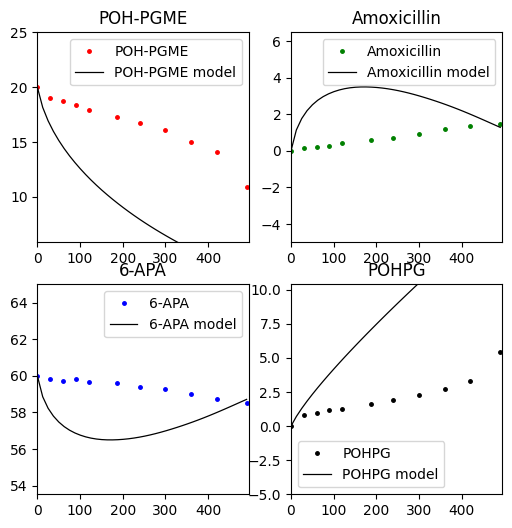

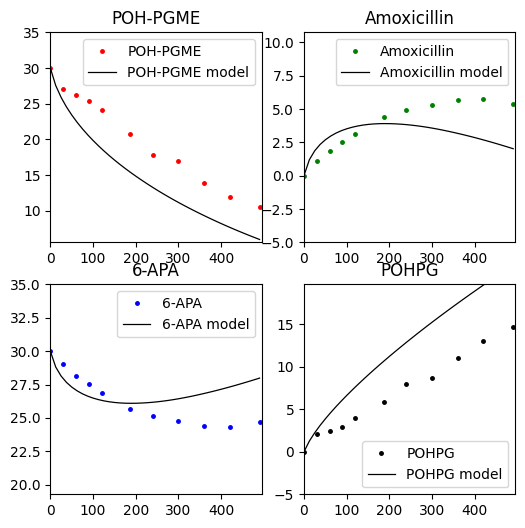

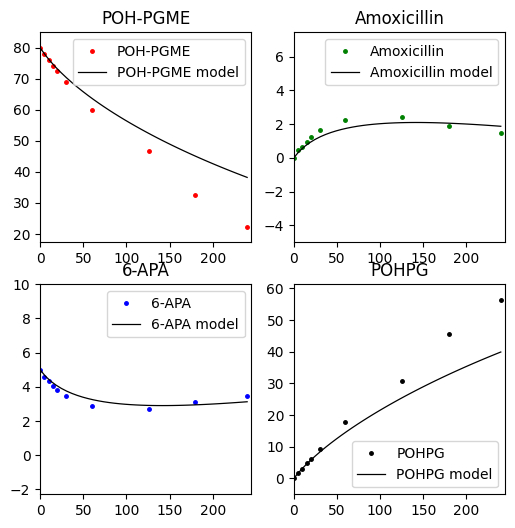

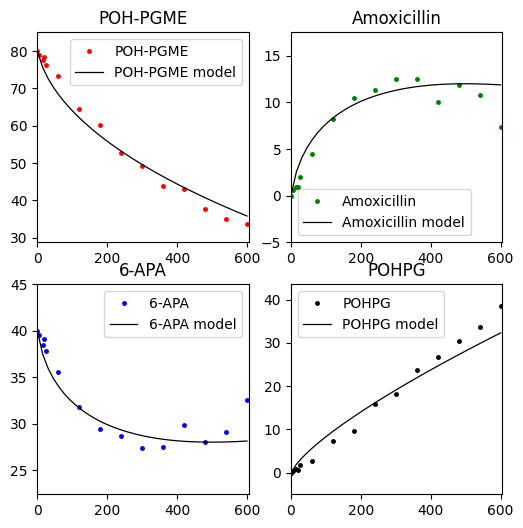

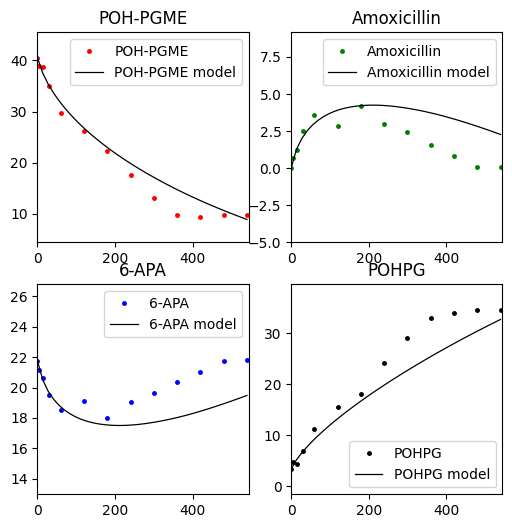

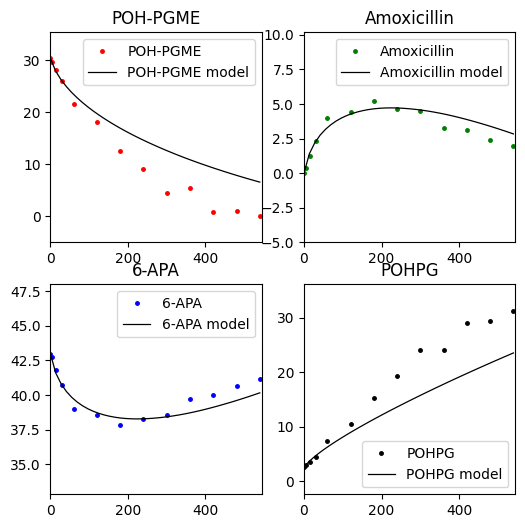

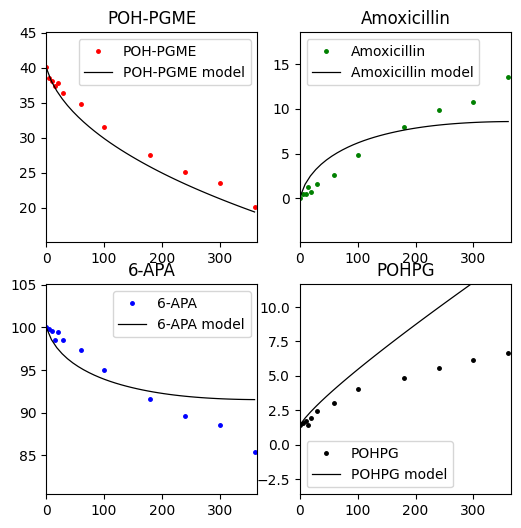

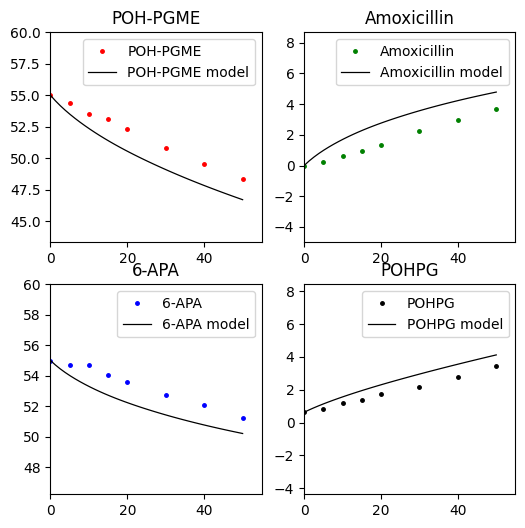

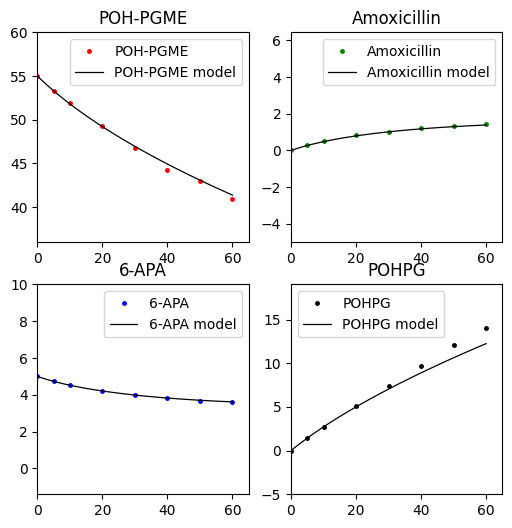

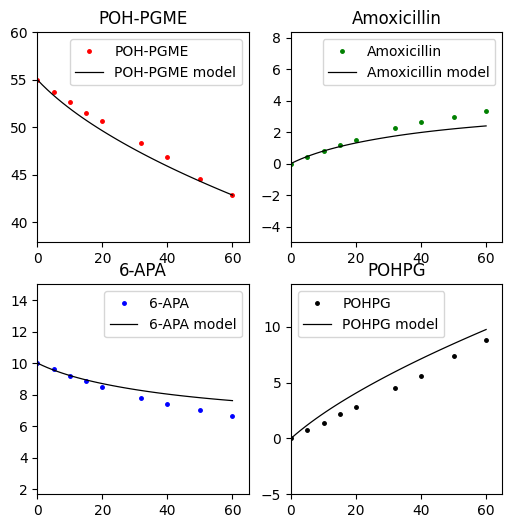

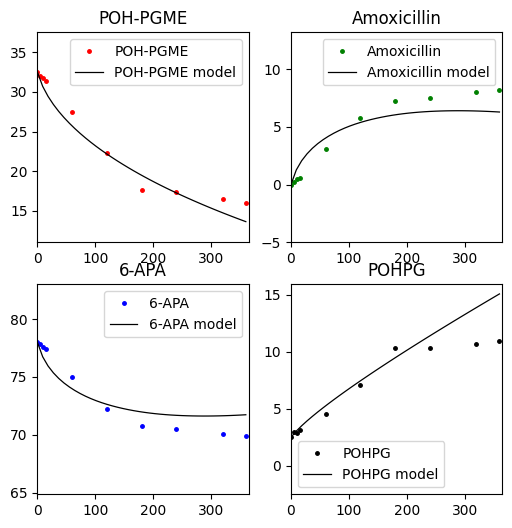

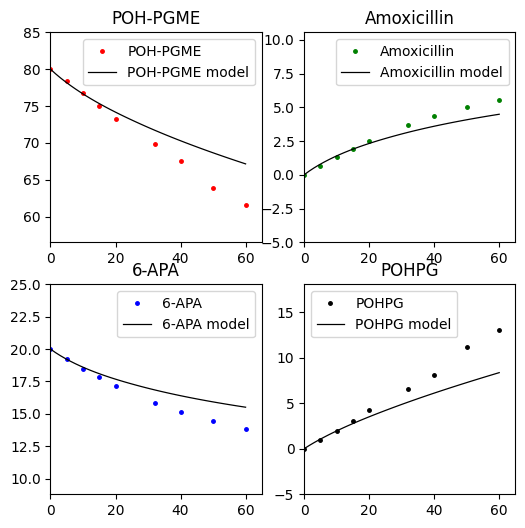

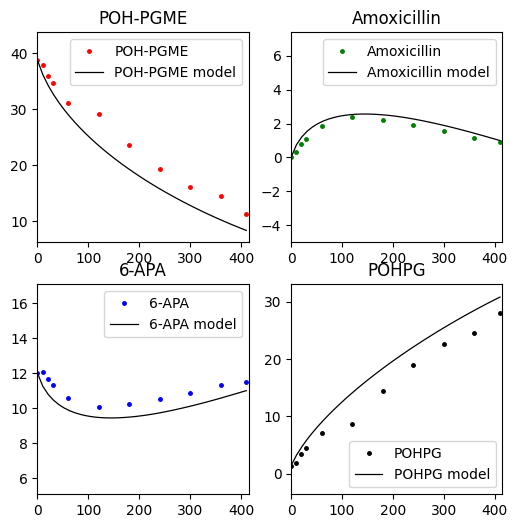

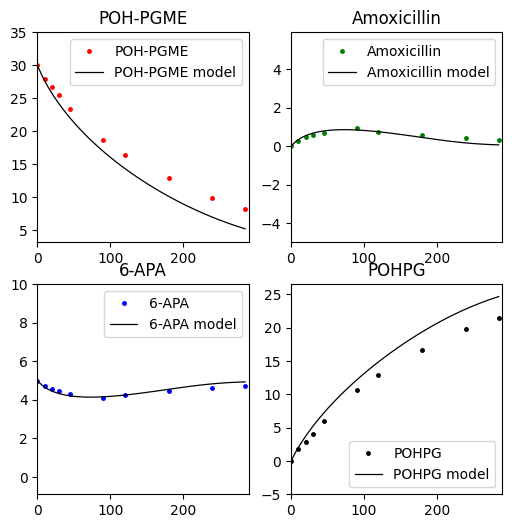

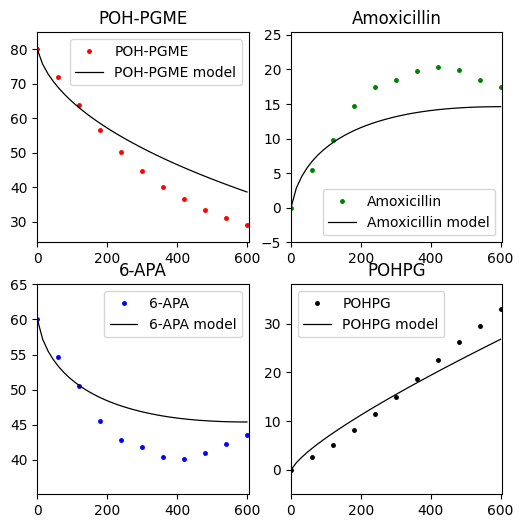

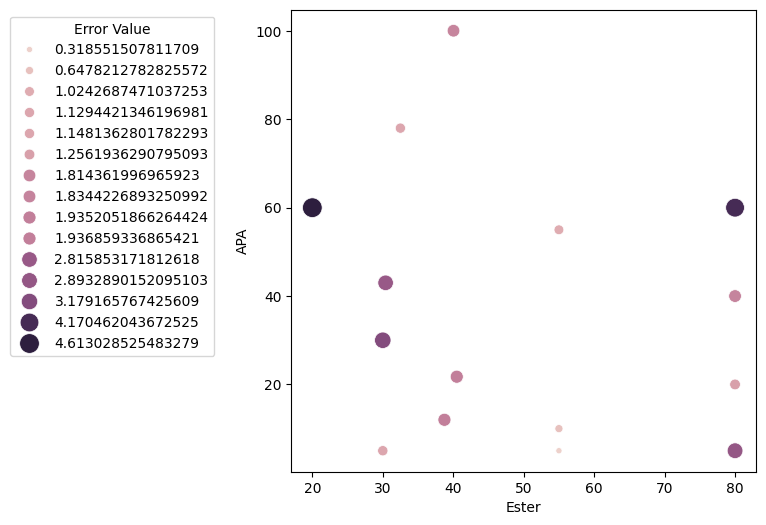

In [80]:
for i in range(len(all_par_df)):
    print(all_parindex[i],eval_performance(all_par_df.iloc[i,:-1].to_numpy()))
eval_all(all_par_df.loc['multi_luci_200000'].to_numpy()[:-1])

In [67]:
def find_best():
    grid = pd.DataFrame(np.zeros((ensaios_dfs[0].shape[0],len(ensaios_dfs))),index=all_parindex,columns=file_list)
    for df,name in zip(ensaios_dfs,file_list_exp):
        for row in df.index:
            P = df.loc[row,:].to_numpy()
            error = eval_performance(P)/len(ensaios_dfs)
            grid.loc[row,name] = error
    return grid
best = find_best()

ValueError: Shape of passed values is (8, 11), indices imply (8, 15)

In [ ]:
# proximo passo é fazer o mesmo para o outro modelo